In [1]:
%matplotlib widget
import os
import sys

import h5py
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

sys.path.insert(0, os.path.abspath(r'C:/Users/mmccann/repos/bonhoeffer/prey_capture/'))

import paths
import functions_matching as fm
import functions_preprocessing as fp
import functions_wirefree_trigger_fix as wf_trig
import snakemake_scripts.sub_preprocess_S1 as s1
import snakemake_scripts.sub_preprocess_S2 as s2
from functions_misc import interp_trace

In [2]:
def preprocess_selector(ref_path, file_info):
    """functions that selects the preprocessing function for the first step, either dlc or not"""
    # check if the input has a dlc path or not
    if (len(file_info['dlc_path']) > 0 and file_info['dlc_path'] != 'N/A') or \
            os.path.isfile(file_info['avi_path'].replace('.avi', '_dlc.h5')):
        # assemble the path here, in case the file wasn't in the database
        dlc_path = file_info['avi_path'].replace('.avi', '_dlc.h5')
        # select function depending on the rig
        if files['rig'] in ['VWheel', 'VWheelWF'] :
            # use the eye specific function
            traces, corner_out, frame_b = s1.run_preprocess_eye(ref_path, dlc_path, file_info)
        else:
            # if there's a dlc file, use this preprocessing
            traces, corner_out, frame_b = s1.run_dlc_preprocess(ref_path, dlc_path, file_info)
    else:
        # if not, use the legacy non-dlc preprocessing
        output_path, traces = s1.run_preprocess(ref_path, file_info)
        # set corners to empty
        corner_out = []
        # set frame bounds to empty
        frame_b = []
    return traces, corner_out, frame_b


def check_frame_code(frame_code, error_limit=5):
    last_change = 0
    count = 0
    # error_start = 0
    start_frame = 0
    error_end = 0
    end_frame = 0
    error_segment = []

    for idx, (frame_a, frame_b) in enumerate(zip(frame_code[:-1], frame_code[1:])):
        idx += 1
        count += 1

        # If we are repeating, but within acceptable limits, continue
        if (frame_b == frame_a) and (count <= error_limit):
            # Do nothing
            pass

        # If we find a change in frame number within the acceptable repeat length, reset the count and record the last change
        elif (frame_b != frame_a) and (count <= error_limit):
            last_change = idx
            count = 0

        # If the frame is repeated for more than n frames, start recording the error region
        elif (frame_b == frame_a) and (count > error_limit):
            # Do nothing
            pass

        elif (frame_b != frame_a)  and (count > error_limit):
            error_end = idx
            start_frame = frame_a
            end_frame = frame_b
            
            error_segment.append([last_change, start_frame, error_end, end_frame])
            
            count = 0

        else:
            pass
                
    return np.array(error_segment)
   

def generate_trigger_sequence(start_num, max_val=3):
    seq_list = []
    for i in np.arange(max_val + 1):
        if i == 0:
            seq_list.append(start_num)
        else:
            if seq_list[i-1] < max_val:
                seq_list.append(seq_list[i-1] + 1)
            else:
                seq_list.append(0)
    return seq_list


def fix_lost_sync_triggers(error_segments, trigger_code):
    for err_seg in error_segments:
        start_idx  = err_seg[0]
        start_frame = err_seg[1]
        end_idx = err_seg[2]
        end_frame = err_seg[3]
        length = end_idx - start_idx

        r = 4    # Repeat factor (empirically determined)
        seq = generate_trigger_sequence(start_frame)
        repeat_seq = np.repeat(seq, r)

        # Generate a vector of "triggers" that matches the theoretical sequence
        replacement_seq = np.tile(repeat_seq, np.ceil(length/len(seq)/r).astype(int))[:length]

        replacement_seq_end = replacement_seq[-1]
        if replacement_seq_end in [0, 1, 2]:
            # Consider this good
            if (replacement_seq_end == end_frame) or (replacement_seq_end == end_frame - 1):
                trigger_code[start_idx:end_idx] = replacement_seq
            else:
                # Hacky hacky
                replacement_seq[-1:] = end_frame - 1
                trigger_code[start_idx:end_idx] = replacement_seq
        if replacement_seq_end == 3:
            if (replacement_seq_end == end_frame) or (end_frame == 0):
                trigger_code[start_idx:end_idx] = replacement_seq
            else:
                replacement_seq[-1:] = 0
                trigger_code[start_idx:end_idx] = replacement_seq

    return trigger_code

In [3]:
basedir = paths.vrexperiment_path
basename = r'01_11_2023_12_13_01_VWheelWF_MM_221109_a_fixed1_gabor'

sync_path = os.path.join(basedir, basename.replace('VWheelWF', 'syncVWheelWF') + '.csv')
track_path = os.path.join(basedir, basename + '.txt')
tif_path = os.path.join(basedir, basename + '.tif')
avi_path = os.path.join(basedir, basename + '.avi')
screen_path = os.path.join(basedir, basename + '.h5')
dlc_path = os.path.join(basedir, basename + '_dlc.h5')
calcium_path = os.path.join(basedir, basename + '_calcium.hdf5')

files = {'sync_path':sync_path,
        'track_path': track_path,
        'screen_path':screen_path,
        'dlc_path':dlc_path,
        'avi_path': avi_path,
        'result': 'free0',
        'rig': 'VTuningWF',
        'imaging': 'wirefree',
        'notes': 'gabor_crickets_0_vrcrickets_0',
        'date': '2023-08-31T12:35:13Z'}

In [ ]:
# load the data for the trial structure and parameters
trials = pd.read_hdf(files['screen_path'], key='trial_set')
params = pd.read_hdf(files['screen_path'], key='params')

# get the video tracking data
filtered_traces, px_corners, frame_bounds = preprocess_selector(files['avi_path'], files)

# define the dimensions of the arena
manual_coordinates = paths.arena_coordinates['VTuningWF']

# get the motive tracking data
motive_traces, reference_coordinates, obstacle_coordinates = \
    s1.extract_motive(files['track_path'], files['rig'])

# scale the traces accordingly
filtered_traces, corners = \
    fp.rescale_pixels(filtered_traces, files, manual_coordinates, px_corners.to_numpy().T)

# align them temporally based on the sync file
filtered_traces = fm.match_motive_2(motive_traces, files['sync_path'], filtered_traces)

# run the preprocessing kinematic calculations
# also saves the data
kinematics_data, real_crickets, vr_crickets = s2.kinematic_calculations(filtered_traces)

# get a dataframe with the calcium data matched to the bonsai data
matched_calcium, roi_info = fm.match_calcium_wf(calcium_path, files['sync_path'], kinematics_data, trials=trials)
_ = wf_trig.get_trial_duration_stats(matched_calcium, 'trial_num', 'time_vector')

In [ ]:
duration_stats_motive = wf_trig.get_trial_duration_stats(motive_traces, 'trial_num', 'time_m')
duration_stats_kinem = wf_trig.get_trial_duration_stats(kinematics_data, 'trial_num', 'time_vector')
duration_stats_matched_ca = wf_trig.get_trial_duration_stats(matched_calcium, 'trial_num', 'time_vector')

print(np.allclose(duration_stats_motive, duration_stats_kinem,  rtol=1e-1, atol=1e-2))
print(np.allclose(duration_stats_kinem, duration_stats_matched_ca,  rtol=1e-1, atol=1e-2))

## explode match_motive_2 to debug

In [ ]:
kinematics_data = filtered_traces

# find the first motive frame
first_motive = np.argwhere(motive_traces.loc[:, 'trial_num'].to_numpy() == 0)[0][0]
# exclude the last frame if it managed to include a single frame of 0
last_motive = -1 if motive_traces.loc[motive_traces.shape[0] - 1, 'trial_num'] == 0 else motive_traces.shape[0]
# trim the motive frames to the start and end of the experiment
trimmed_traces = motive_traces.iloc[first_motive:last_motive, :].reset_index(drop=True)
# TODO: remove this for regular trials, only here for 21.2.2022 ones
if np.max(trimmed_traces.loc[:, 'color_factor']) > 81:
    trimmed_traces.loc[:, 'color_factor'] = trimmed_traces.loc[:, 'color_factor'] / 255
# normalize the number to 0 1 2 3 range
trimmed_traces.loc[:, 'color_factor'] = np.array([int('0b' + format(int(el) - 1, '#09b')[2] +
                                                        format(int(el) - 1, '#09b')[4], 2)
                                                    if el > 0 else 0 for el in trimmed_traces.loc[:, 'color_factor']])

# load the sync data
sync_data = pd.read_csv(sync_path, names=['Time', 'projector_frames', 'camera_frames',
                                            'sync_trigger', 'mini_frames', 'wheel_frames', 'projector_frames_2'],
                        index_col=False)
# get the camera frames (as the indexes from sync_frames are referenced for the uncut sync_data, see match_dlc)
frame_times_cam_sync = sync_data.loc[kinematics_data['sync_frames'].to_numpy(), 'Time'].to_numpy()

# get the start and end triggers
sync_start = np.argwhere(sync_data.loc[:, 'sync_trigger'].to_numpy() == 1)[0][0] - 1
sync_end = np.argwhere(sync_data.loc[:, 'sync_trigger'].to_numpy() == 2)[0][0]

# trim the sync data to the experiment
sync_data = sync_data.iloc[sync_start:sync_end, :].reset_index(drop=True)

# get the motive frame times
# TODO: probs remove this later, since all trials should be on the new rig with the 2bit frame encoding
if np.any(np.isnan(sync_data['projector_frames_2'])):
    # get the frame indexes
    idx_code = np.argwhere(np.abs(np.diff(np.round(sync_data.loc[:, 'projector_frames'] / 4))) > 0).squeeze() + 1
    # get the frame times
    frame_times_motive_sync = sync_data.loc[idx_code, 'Time'].to_numpy()
    # if the number of frames doesn't match, trim from the end
    if trimmed_traces.shape[0] > frame_times_motive_sync.shape[0]:
        trimmed_traces = trimmed_traces.iloc[-frame_times_motive_sync.shape[0]:, :]
    elif trimmed_traces.shape[0] < frame_times_motive_sync.shape[0]:
        frame_times_motive_sync = frame_times_motive_sync[-trimmed_traces.shape[0]:]

else:
    # This is all from sync file
    # binarize both frame streams
    frames_0 = np.round(sync_data.loc[:, 'projector_frames'] / 4).astype(int) * 2
    frames_1 = np.round(sync_data.loc[:, 'projector_frames_2'] / 4).astype(int)
    # assemble the actual sequence
    frame_code = (frames_0 | frames_1).to_numpy()

In [ ]:
kinematics_data = filtered_traces

# find the first motive frame
first_motive = np.argwhere(motive_traces.loc[:, 'trial_num'].to_numpy() == 0)[0][0]
# exclude the last frame if it managed to include a single frame of 0
last_motive = -1 if motive_traces.loc[motive_traces.shape[0] - 1, 'trial_num'] == 0 else motive_traces.shape[0]
# trim the motive frames to the start and end of the experiment
trimmed_traces = motive_traces.iloc[first_motive:last_motive, :].reset_index(drop=True)
# TODO: remove this for regular trials, only here for 21.2.2022 ones
if np.max(trimmed_traces.loc[:, 'color_factor']) > 81:
    trimmed_traces.loc[:, 'color_factor'] = trimmed_traces.loc[:, 'color_factor'] / 255
# normalize the number to 0 1 2 3 range
trimmed_traces.loc[:, 'color_factor'] = np.array([int('0b' + format(int(el) - 1, '#09b')[2] +
                                                        format(int(el) - 1, '#09b')[4], 2)
                                                    if el > 0 else 0 for el in trimmed_traces.loc[:, 'color_factor']])

# load the sync data
sync_data = pd.read_csv(sync_path, names=['Time', 'projector_frames', 'camera_frames',
                                            'sync_trigger', 'mini_frames', 'wheel_frames', 'projector_frames_2'],
                        index_col=False)
# get the camera frames (as the indexes from sync_frames are referenced for the uncut sync_data, see match_dlc)
frame_times_cam_sync = sync_data.loc[kinematics_data['sync_frames'].to_numpy(), 'Time'].to_numpy()

# get the start and end triggers
sync_start = np.argwhere(sync_data.loc[:, 'sync_trigger'].to_numpy() == 1)[0][0] - 1
sync_end = np.argwhere(sync_data.loc[:, 'sync_trigger'].to_numpy() == 2)[0][0]

# trim the sync data to the experiment
sync_data = sync_data.iloc[sync_start:sync_end, :].reset_index(drop=True)

# get the motive frame times
# TODO: probs remove this later, since all trials should be on the new rig with the 2bit frame encoding
if np.any(np.isnan(sync_data['projector_frames_2'])):
    # get the frame indexes
    idx_code = np.argwhere(np.abs(np.diff(np.round(sync_data.loc[:, 'projector_frames'] / 4))) > 0).squeeze() + 1
    # get the frame times
    frame_times_motive_sync = sync_data.loc[idx_code, 'Time'].to_numpy()
    # if the number of frames doesn't match, trim from the end
    if trimmed_traces.shape[0] > frame_times_motive_sync.shape[0]:
        trimmed_traces = trimmed_traces.iloc[-frame_times_motive_sync.shape[0]:, :]
    elif trimmed_traces.shape[0] < frame_times_motive_sync.shape[0]:
        frame_times_motive_sync = frame_times_motive_sync[-trimmed_traces.shape[0]:]

else:
    # This is all from sync file
    # binarize both frame streams
    frames_0 = np.round(sync_data.loc[:, 'projector_frames'] / 4).astype(int) * 2
    frames_1 = np.round(sync_data.loc[:, 'projector_frames_2'] / 4).astype(int)
    # assemble the actual sequence
    frame_code = (frames_0 | frames_1).to_numpy()

    # NEED TO FIND WHERE CONSECUTIVE CODES EXCEED THRESHOLD AND FIX
    # Found that in general, the sync frame code dwells for 3 or 4 frames per code. 
    # We can generate a sequnce bewteen the start and end codes that should somewhat match the real triggers
    error_segments_sync = check_frame_code(frame_code, error_limit=7)
    frame_code = fix_lost_sync_triggers(error_segments_sync, frame_code)
    error_segments_sync_2 = check_frame_code(frame_code, error_limit=7)

    # TODO: turn this into a function
    fixed_code = frame_code.copy()

    # for all the frames
    for idx, frame in enumerate(frame_code[1:-1]):
        idx += 1
        # if it's the same number as before, skip
        if frame == fixed_code[idx - 1]:
            continue
        # if the numbers before and after are equal
        if fixed_code[idx - 1] == frame_code[idx + 1]:
            # replace this position by the repeated number cause it's likely a mistake
            fixed_code[idx] = frame_code[idx - 1]
            continue
        # if not, start filtering
        # first check for 0-2, cause 3 is a special case
        if fixed_code[idx - 1] in [0, 1, 2]:
            if frame != fixed_code[idx - 1] + 1:
                fixed_code[idx] = fixed_code[idx - 1] + 1
                continue
        else:
            if frame != 0:
                fixed_code[idx] = 0
                continue

    # get the motive-based frame code in sync
    idx_code = np.argwhere(np.abs(np.diff(fixed_code)) > 0).squeeze() + 1
    motive_code = fixed_code[idx_code]
    # if the frame numbers don't match, find the first motive color number and match that
    last_number = trimmed_traces.loc[trimmed_traces.shape[0] - 1, 'color_factor']
    # trim the idx based on the last appearance of the last_number in motive_code
    trim_idx = np.argwhere(motive_code == last_number)[-1][0] + 1
    idx_code = idx_code[-(trimmed_traces.shape[0] + 1):trim_idx]
    # if idx_code.shape[0] < trimmed_traces.shape[0]:
    #
    #     # get the difference in frames
    #     delta_frames = trimmed_traces.shape[0] - idx_code.shape[0]
    #     # get trimmed traces trimmed
    #     idx_code = idx_code[delta_frames:]
    # display_code = fixed_code[idx_code]
    
    # get the frame times
    frame_times_motive_sync = sync_data.loc[idx_code, 'Time'].to_numpy()
    
    # trim the motive frames to be contained within the camera frames
    if frame_times_motive_sync[0] < frame_times_cam_sync[0]:
        start_idx = np.argwhere(frame_times_motive_sync > frame_times_cam_sync[0])[0][0]
        frame_times_motive_sync = frame_times_motive_sync[start_idx:]
        idx_code = idx_code[start_idx:]
        trimmed_traces = trimmed_traces.iloc[start_idx:, :].reset_index(drop=True)
    
    if frame_times_motive_sync[-1] > frame_times_cam_sync[-1]:
        end_idx = np.argwhere(frame_times_motive_sync < frame_times_cam_sync[-1])[-1][0] + 1
        frame_times_motive_sync = frame_times_motive_sync[:end_idx]
        idx_code = idx_code[:end_idx]
        trimmed_traces = trimmed_traces.iloc[:end_idx, :].reset_index(drop=True)

    if trimmed_traces.shape[0] > frame_times_motive_sync.shape[0]:
        delta_frames = trimmed_traces.shape[0] - frame_times_motive_sync.shape[0]
        trimmed_traces = trimmed_traces.iloc[delta_frames:, :].reset_index(drop=True)

# interpolate the camera traces to match the unity frames
matched_camera = kinematics_data.drop(['time_vector', 'mouse', 'datetime', 'sync_frames'],
                                        axis=1).apply(interp_trace, raw=False, args=(frame_times_cam_sync,
                                                                                    frame_times_motive_sync))

# add the correct time vector from the interpolated traces
matched_camera['time_vector'] = frame_times_motive_sync
matched_camera['mouse'] = kinematics_data.loc[kinematics_data.index[0], 'mouse']
matched_camera['datetime'] = kinematics_data.loc[kinematics_data.index[0], 'datetime']
# correct the frame indexes to work with the untrimmed sync file
idx_code += sync_start
matched_camera['sync_frames'] = idx_code

# concatenate both data frames
full_dataframe = pd.concat([matched_camera, trimmed_traces.drop(['time_m', 'color_factor'], axis=1)], axis=1)

# reset the time vector
old_time = full_dataframe['time_vector']
full_dataframe['time_vector'] = np.array([el - old_time[0] for el in old_time])


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(211)
# ax.scatter(sync_data.loc[:, 'Time'], sync_data.loc[:, 'projector_frames'])
ax.scatter(sync_data.loc[:, 'Time'], sync_data.loc[:, 'camera_frames'])
ax.scatter(sync_data.loc[:, 'Time'], np.round(sync_data.loc[:, 'projector_frames']/4)*4)
ax.scatter(frame_times_motive_sync, np.ones_like(frame_times_motive_sync))

fig2 = plt.figure()
ax = fig2.add_subplot(211)
# ax.plot(np.diff(motive_traces.loc[:, 'time_m']))
ax.plot(frame_times_motive_sync[1:], np.diff(frame_times_motive_sync))

fig3 = plt.figure()
ax = fig3.add_subplot(211)
ax.plot(sync_data.loc[1:, 'Time'], np.diff(frame_code))
ax.plot(sync_data.loc[1:, 'Time'], np.diff(fixed_code))

fig4 = plt.figure()
ax = fig4.add_subplot(211)
# ax.plot(sync_data.loc[:, 'Time'], sync_data.loc[:, 'projector_frames'])
ax.plot(sync_data.loc[:, 'Time'], sync_data.loc[:, 'sync_trigger'])
ax.scatter(frame_times_motive_sync, np.ones_like(frame_times_motive_sync))


fig5 = plt.figure()
ax = fig5.add_subplot(211)
ax.plot(trimmed_traces.loc[:, 'time_m'], trimmed_traces.loc[:, 'trial_num'])
# ax.plot(trimmed_traces.loc[:, 'time_m'], trimmed_traces.loc[:, 'sync_trigger'])

fig6 = plt.figure()
ax = fig6.add_subplot(111)
ax.plot(np.diff(motive_code), marker='o')


In [ ]:
kinematics_data = full_dataframe.copy()
duration_stats_motive = get_trial_duration_stats(motive_traces, 'trial_num', 'time_m')
duration_stats_kinem = get_trial_duration_stats(kinematics_data, 'trial_num', 'time_vector')
np.allclose(duration_stats_motive, duration_stats_kinem, rtol=1e-1, atol=1e-2)

## It's not the kinematics matching that's throwing the error, it's `match_calcium_wf`

In [ ]:
# TODO ERROR ALSO HERE
# THIS ONE COMES FROM THE MINISCOPE TRIGGERS FAILING (???)
matched_calcium, roi_info = fm.match_calcium_wf(calcium_path, files['sync_path'], kinematics_data, trials=trials)
duration_stats_matched_ca = get_trial_duration_stats(matched_calcium, 'trial_num', 'time_vector')

print(duration_stats_motive)
print(duration_stats_kinem)
print(duration_stats_matched_ca)
np.allclose(duration_stats_kinem, duration_stats_matched_ca,  rtol=1e-1, atol=1e-2)

## Explode 'match_calcium_wf' to debug

In [ ]:
# load the calcium data (cells x time), transpose to get time x cells
with h5py.File(calcium_path, mode='r') as f:
    calcium_data = np.array(f['calcium_data']).T
    fluor_data = np.array(f['fluor_data']).T

# load the sync data
sync_data = pd.read_csv(sync_path, header=None)
if sync_data.shape[1] == 3:
    sync_data.columns = ['Time', 'mini_frames', 'camera_frames']
elif sync_data.shape[1] == 6:
    # TODO: only for files from 21.02.2022
    sync_data.columns = ['Time', 'projector_frames', 'camera_frames',
                            'sync_trigger', 'mini_frames', 'wheel_frames']
else:
    sync_data.columns = ['Time', 'projector_frames', 'camera_frames',
                            'sync_trigger', 'mini_frames', 'wheel_frames', 'projector_frames_2']

# get the camera frame times
frame_idx_camera_sync = kinematics_data['sync_frames'].to_numpy().astype(int)
frame_times_camera_sync = sync_data.loc[frame_idx_camera_sync, 'Time'].to_numpy()

In [ ]:
%matplotlib widget
# Sometimes there are weird segments where the mini frame triggers aren't recorded in the middle of a session. 
# These are large gaps that are obvious
# get the miniscope frame indexes from the sync file
fig = plt.figure()
mini_frame_triggers = np.round(sync_data.loc[:, 'mini_frames']).astype(int)
plt.plot(mini_frame_triggers)
plt.show()


In [ ]:
frame_idx_mini_sync = np.argwhere(np.diff(np.round(sync_data.loc[:, 'mini_frames'])) > 0).squeeze() + 1
print(calcium_data.shape[0])
print(np.sum(mini_frame_triggers > 0))
print(frame_idx_mini_sync.shape[0])

In [ ]:
 # get the miniscope frame indexes from the sync file
frame_idx_mini_sync = np.argwhere(np.diff(np.round(sync_data.loc[:, 'mini_frames'])) > 0).squeeze() + 1
frame_times_mini_sync = sync_data.loc[frame_idx_mini_sync, 'Time'].to_numpy()
# interpolate missing triggers (based on experience)
# frame_idx_mini_sync = np.round(interpolate_frame_triggers(frame_idx_mini_sync)).astype(int)
# print(frame_idx_mini_sync.shape[0])

In [ ]:
print(frame_idx_mini_sync[0], frame_idx_mini_sync[-1])
print(frame_idx_camera_sync[0], frame_idx_camera_sync[-1])
print(calcium_data.shape[0])

# correct for the calcium starting before and/or ending after the behavior
if frame_idx_mini_sync[0] < frame_idx_camera_sync[0]:
    start_idx = np.argwhere(frame_idx_mini_sync > frame_idx_camera_sync[0])[0][0]
    print(start_idx)
    frame_idx_mini_sync = frame_idx_mini_sync[start_idx:]
    calcium_data = calcium_data[start_idx:, :]
    fluor_data = fluor_data[start_idx:, :]

if frame_idx_mini_sync[-1] > frame_idx_camera_sync[-1]:
    end_idx = np.argwhere(frame_idx_mini_sync < frame_idx_camera_sync[-1])[-1][0] + 1
    print(end_idx)
    frame_idx_mini_sync = frame_idx_mini_sync[:end_idx]
    calcium_data = calcium_data[:end_idx, :]
    fluor_data = fluor_data[:end_idx, :]

print(frame_idx_mini_sync[0], frame_idx_mini_sync[-1])
print(frame_idx_camera_sync[0], frame_idx_camera_sync[-1])

print(calcium_data.shape[0])
print(frame_idx_mini_sync.shape[0])

# get the delta frames with the calcium
delta_frames = frame_idx_mini_sync.shape[0] - calcium_data.shape[0]

# remove extra detections coming from terminating the calcium mid frame (I think)
if delta_frames > 0:
    print(f'There were {delta_frames} triggers more than frames on file {os.path.basename(calcium_path)}')
    frame_idx_mini_sync = frame_idx_mini_sync[:-delta_frames]
elif delta_frames < 0:
    print(f'There were {-delta_frames} more frames than triggers on file {os.path.basename(calcium_path)}')
    calcium_data = calcium_data[:delta_frames, :]
    fluor_data = fluor_data[:delta_frames, :]

In [ ]:
fig = plt.figure()
plt.plot(frame_times_mini_sync)
plt.plot(frame_times_camera_sync)
plt.show()

In [ ]:
# trim calcium according to the frames left within the behavior
calcium_data = calcium_data[frame_idx_mini_sync > frame_idx_camera_sync[0], :]
fluor_data = fluor_data[frame_idx_mini_sync > frame_idx_camera_sync[0], :]

# and then remove frames before the behavior starts
frame_idx_mini_sync = frame_idx_mini_sync[frame_idx_mini_sync > frame_idx_camera_sync[0]]

# get the actual mini times
frame_times_mini_sync = sync_data.loc[frame_idx_mini_sync, 'Time'].to_numpy()

# interpolate the bonsai traces to match the mini frames
matched_bonsai = kinematics_data.drop(['time_vector', 'sync_frames', 'mouse', 'datetime'], axis=1).apply(interp_trace, raw=False, args=(frame_times_camera_sync, frame_times_mini_sync))

In [ ]:
if trials is not None:

    # repair the trial_num column
    trial_nums = matched_bonsai.trial_num
    real_trials = np.concatenate([[0], trials.index + 1])
    incorrect_trial_assignments = ~np.isin(matched_bonsai.loc[:, 'trial_num'], real_trials)
    incorrect_trial_idxs = matched_bonsai.index[incorrect_trial_assignments]
    
    # Check preceding or following frames for the correct trial number
    for idx in incorrect_trial_idxs:
        trial_val = matched_bonsai.loc[idx, 'trial_num']
        rounded_trial = np.round(trial_val)
        prec_trial = matched_bonsai.loc[idx - 1, 'trial_num']
        next_trial = matched_bonsai.loc[idx + 1, 'trial_num']
        
        if (rounded_trial == prec_trial) and (next_trial == 0):
            matched_bonsai.loc[idx, 'trial_num'] = prec_trial
        elif (rounded_trial == next_trial) and (prec_trial == 0):
            matched_bonsai.loc[idx, 'trial_num'] = next_trial
        elif (rounded_trial == prec_trial) and (rounded_trial == next_trial):
            matched_bonsai.loc[idx, 'trial_num'] = prec_trial
        else:
            matched_bonsai.loc[idx, 'trial_num'] = 0
    
    matched_bonsai.loc[:, 'trial_num'] = np.round(matched_bonsai.loc[:, 'trial_num'])

    # find indexes for each trial number > 0. If there are some that aren't consecutive, fix them
    # Seems to be the case the sometimes the transition is split across two frames
    for trial in matched_bonsai.trial_num.unique():
        indexes = matched_bonsai.index[matched_bonsai.trial_num == trial]
        if np.any(np.diff(indexes) != 1):
            where_bad = np.argwhere(np.diff(indexes) > 1).squeeze() + 1
            matched_bonsai.loc[indexes[where_bad], 'trial_num'] = 0

    # # now that the trials are reassigned, add the trial data
    matched_bonsai = fm.assign_trial_parameters(matched_bonsai, trials)

else:
    # round the quadrant vector as it should be discrete
    quadrant_columns = [el for el in matched_bonsai.columns if ('_quadrant' in el)]

    for el in quadrant_columns:
        matched_bonsai[el] = np.round(matched_bonsai[el])

    # same for the hunt trace
    if 'hunt_trace' in matched_bonsai.columns:
        matched_bonsai.loc[:, 'hunt_trace'] = np.round(matched_bonsai.loc[:, 'hunt_trace'])

# add the correct time vector from the interpolated traces, plus mouse and datetime
matched_bonsai['time_vector'] = frame_times_mini_sync
matched_bonsai['mouse'] = kinematics_data.loc[0, 'mouse']
matched_bonsai['datetime'] = kinematics_data.loc[0, 'datetime']

In [ ]:
a = matched_bonsai.trial_num.value_counts()

In [ ]:
fig = plt.figure()
plt.plot(matched_bonsai.time_vector, matched_bonsai.trial_num)
plt.plot(matched_bonsai.time_vector, matched_bonsai.trial_num == 5)
plt.plot(matched_bonsai.time_vector, matched_bonsai.trial_num == 15)
plt.show()

In [ ]:
# print a single dataframe with the calcium matched positions and timestamps
cell_column_names = ['_'.join(('cell', f'{el:04d}', 'spikes')) for el in range(calcium_data.shape[1])]
calcium_dataframe = pd.DataFrame(calcium_data, columns=cell_column_names)
cell_column_names = [col.replace('spikes', 'fluor') for col in cell_column_names]
fluorescence_dataframe = pd.DataFrame(fluor_data, columns=cell_column_names)
# concatenate both data frames
full_dataframe = pd.concat([matched_bonsai, calcium_dataframe, fluorescence_dataframe], axis=1)

# reset the time vector
old_time = full_dataframe['time_vector']
full_dataframe.loc[:, 'time_vector'] = np.array([el - old_time[0] for el in old_time])

# turn the roi info into a dataframe
roi_info = pd.DataFrame(roi_info, columns=['centroid_x', 'centroid_y',
                                            'bbox_left', 'bbox_top', 'bbox_width', 'bbox_height', 'area'])

full_dataframe = full_dataframe.dropna()

In [ ]:
fig = plt.figure()
plt.plot(full_dataframe.trial_num == 2)
plt.show()

In [ ]:
duration_stats_full = wf_trig.get_trial_duration_stats(full_dataframe, 'trial_num', 'time_vector')

print(duration_stats_motive)
print(duration_stats_kinem)
print(duration_stats_full)
np.allclose(duration_stats_kinem, duration_stats_full,  rtol=1e-1, atol=1e-2)

In [ ]:
grouped_trials = full_dataframe.loc[full_dataframe['trial_num'] != 0]
grouped_trials = grouped_trials.groupby('trial_num')
trial_durations = grouped_trials.apply(lambda x: x['time_vector'].to_list()[-1] - x['time_vector'].to_list()[0])
# print(trial_durations.min(), trial_durations.max(), trial_durations.mean())
trial_range = grouped_trials.apply(lambda x: (x['time_vector'].to_list()[0], x['time_vector'].to_list()[-1]))
trial_range

## Load the tiff and extract triggers to check

In [4]:
from functions_wirefree_trigger_fix import extract_timestamp, correct_timestamp_jumps, update_sync_file

In [5]:
stack = io.imread(tif_path)

In [6]:
timestamps = np.array([extract_timestamp(el)/1000 for el in stack])
corrected_timestamps , idxs, _= correct_timestamp_jumps(timestamps)

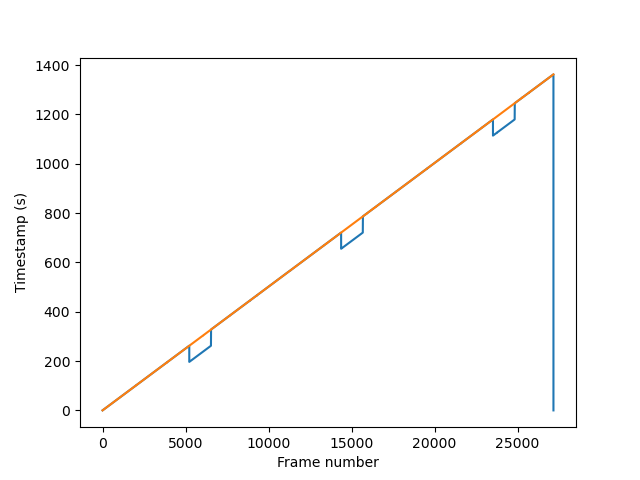

In [7]:
fig = plt.figure()
plt.plot(timestamps)
plt.plot(corrected_timestamps)
plt.xlabel('Frame number')
plt.ylabel('Timestamp (s)')
plt.show()

In [8]:
sync_data_original = pd.read_csv(sync_path.replace('.csv', '_original.csv'), header=None)
sync_data_original.columns = ['Time', 'projector_frames', 'camera_frames',
                             'sync_trigger', 'mini_frames', 'wheel_frames', 'projector_frames_2']

sync_data = pd.read_csv(sync_path, header=None)
sync_data.columns = ['Time', 'projector_frames', 'camera_frames',
                             'sync_trigger', 'mini_frames', 'wheel_frames', 'projector_frames_2']

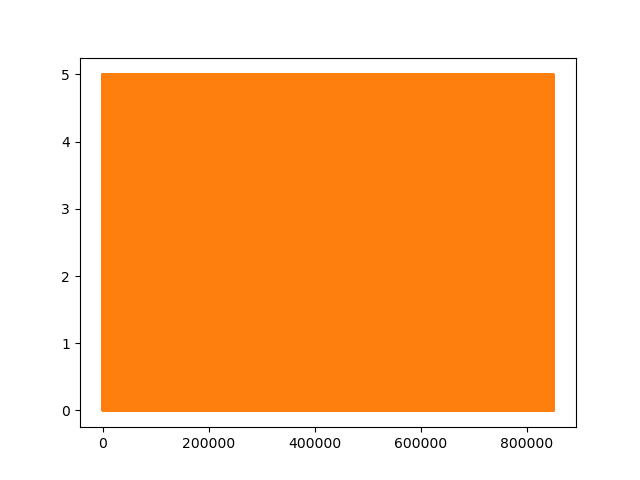

In [9]:
fig = plt.figure()
plt.plot(np.round(sync_data_original.mini_frames))
plt.plot(np.round(sync_data.mini_frames))
plt.show()

In [10]:
# There are still these little mistakes throughout that cause timing errors down the line. 
# Let's try to fix them by interpolating the timestamps
slope, intercept = np.polyfit(np.arange(len(corrected_timestamps)-1), corrected_timestamps[:-1], deg=1)
regressed_timestamps = np.arange(len(corrected_timestamps)) * slope + intercept

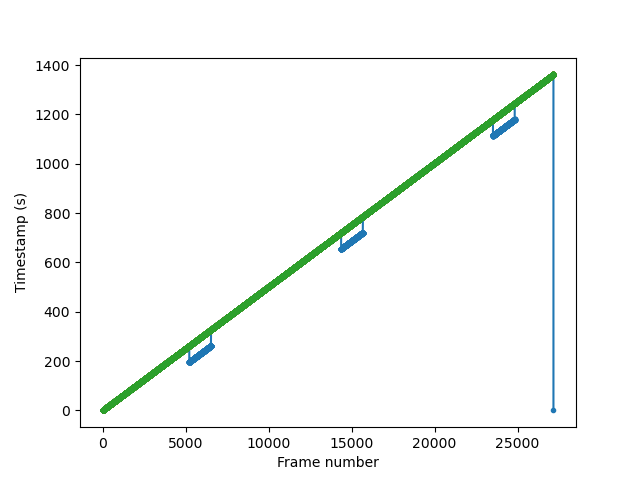

In [12]:
fig = plt.figure()
plt.plot(timestamps, marker='.')
plt.plot(corrected_timestamps, marker='.')
plt.plot(regressed_timestamps, marker='.')
plt.xlabel('Frame number')
plt.ylabel('Timestamp (s)')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(corrected_timestamps - regressed_timestamps)
plt.xlabel('Frame number')
plt.ylabel('Timestamp (s)')
plt.show()

In [ ]:
interp_idxs = np.argwhere(np.abs(corrected_timestamps - regressed_timestamps) > 0.05).squeeze()
corrected_timestamps[interp_idxs] = regressed_timestamps[interp_idxs]

In [ ]:
fig = plt.figure()
plt.plot(timestamps)
plt.plot(corrected_timestamps)
plt.plot(regressed_timestamps)
plt.xlabel('Frame number')
plt.ylabel('Timestamp (s)')
plt.show()

In [ ]:
update_sync_file(corrected_timestamps, sync_path)

## Use snakemake to get a sense of how many experiments are affected

In [ ]:
import functions_data_handling as fdh
import functions_bondjango as bd
from tqdm import tqdm

In [ ]:
mice = [# 'MM_221110_a', 'MM_221109_a', 'MM_220928_a', 'MM_220915_a', 'MM_230518_b', 'MM_230705_b', 
       'MM_230706_a', 'MM_230706_b']

rigs = ['VTuningWF', 'VWheelWF']

num_files = 0
affected_files = 0

for mouse in mice:
    for rig in rigs:
        # get the search string
        search_string = f"mouse:{mouse}, rig:{rig}"
        parsed_search = fdh.parse_search_string(search_string)
        
        # get the paths from the database
        file_infos = bd.query_database("vr_experiment", search_string)
        
        for file_info in tqdm(file_infos):
            num_files += 1
            tif_path = file_info['tif_path']
            sync_path = file_info['sync_path']
            
            # Load tif and check for timestamp weirdness
            stack = io.imread(tif_path)
            timestamps = np.array([extract_timestamp(el)/1000 for el in stack])
            corrected_timestamps , idxs, _= correct_shifted_timestamps(timestamps)

            if len(idxs) > 0:
                affected_files += 1
                
print(f'Fraction of files affected: {affected_files / num_files}')